# Phase 2 — Full Pipeline with Reranking

Independent pipeline that extracts its own memories, builds its own database and test cases,
then runs retrieval experiments with cross-encoder reranking.

Unlike `phase1_reranking_comparison.ipynb` (which reuses Phase 1 data), this notebook
owns its entire pipeline end-to-end, allowing independent prompt/extraction iteration.

In [32]:
# Cell 1 — Setup & Imports
import os
from pathlib import Path

from memory_retrieval.experiments.query_generation import (
    QueryGenerationConfig,
    generate_all_queries,
)
from memory_retrieval.experiments.runner import ExperimentConfig, run_all_experiments
from memory_retrieval.experiments.test_cases import build_test_cases
from memory_retrieval.infra.io import load_json
from memory_retrieval.infra.runs import (
    PHASE2,
    create_run,
    update_run_status,
)
from memory_retrieval.memories.extractor import ExtractionConfig, SituationFormat, extract_memories
from memory_retrieval.search.reranker import Reranker
from memory_retrieval.search.vector import VectorBackend

# Find project root by walking up to pyproject.toml
PROJECT_ROOT = Path.cwd()
while not (PROJECT_ROOT / "pyproject.toml").exists():
    if PROJECT_ROOT.parent == PROJECT_ROOT:
        raise RuntimeError("Could not find project root (pyproject.toml)")
    PROJECT_ROOT = PROJECT_ROOT.parent
os.chdir(PROJECT_ROOT)

# Verify API key
if not os.environ.get("OPENROUTER_API_KEY"):
    print("WARNING: OPENROUTER_API_KEY is not set. Memory building and query generation will fail.")
else:
    print("OPENROUTER_API_KEY is set.")

print(f"Project root: {PROJECT_ROOT}")
print("Imports OK.")

OPENROUTER_API_KEY is set.
Project root: /Users/mayk/Projects/private/crm-memory-retrieval-research
Imports OK.


In [33]:
# Cell 2 — Configuration

PROMPT_VERSION = "3.0.0"
MODEL_MEMORIES = "anthropic/claude-haiku-4.5"  # LLM for memory extraction
MODEL_EXPERIMENT = "anthropic/claude-sonnet-4.5"  # LLM for query generation

RAW_DATA_DIR = "data/review_data"

# Reranking configuration
RERANK_TOP_N = 6  # Final results after reranking
SEARCH_LIMIT = 20  # Vector search candidates per query
DISTANCE_THRESHOLD = 1.1  # For pre-rerank metrics comparison

# Rerank text strategies: compare reranking on situation-only vs situation+lesson
RERANK_TEXT_STRATEGIES = {
    "situation_only": lambda c: c["situation"],
    "situation_and_lesson": lambda c: f"situation: {c['situation']}; lesson: {c.get('lesson', '')}",
}

# Run selection: use latest run or select a specific one
# To create a new run: RUN_DIR = None (will be created in Step 1)
# To see available runs: print(list_runs(PHASE2))
# To select specific run: RUN_DIR = get_run(PHASE2, "run_20260209_120000")
# RUN_DIR = get_latest_run(PHASE2)
RUN_DIR = None

# Derived paths (automatic from run directory)
if RUN_DIR is not None:
    MEMORIES_DIR = str(RUN_DIR / "memories")
    DB_PATH = str(RUN_DIR / "memories" / "memories.db")
    TEST_CASES_DIR = str(RUN_DIR / "test_cases")
    QUERIES_DIR = str(RUN_DIR / "queries")
    RESULTS_DIR = str(RUN_DIR / "results")

# Initialize backends
vector_backend = VectorBackend()

print("Configuration:")
print(f"  Using run: {RUN_DIR.name if RUN_DIR else 'None (will create new)'}")
print(f"  Prompt version: {PROMPT_VERSION}")
print(f"  Model (memories): {MODEL_MEMORIES}")
print(f"  Model (experiment): {MODEL_EXPERIMENT}")
print(f"  Rerank top-n: {RERANK_TOP_N}")
print(f"  Search limit: {SEARCH_LIMIT}")
print(f"  Distance threshold: {DISTANCE_THRESHOLD}")
print(f"  Rerank strategies: {list(RERANK_TEXT_STRATEGIES.keys())}")
print(f"  Raw data dir: {RAW_DATA_DIR}")

Configuration:
  Using run: None (will create new)
  Prompt version: 3.0.0
  Model (memories): anthropic/claude-haiku-4.5
  Model (experiment): anthropic/claude-sonnet-4.5
  Rerank top-n: 6
  Search limit: 20
  Distance threshold: 1.1
  Rerank strategies: ['situation_only', 'situation_and_lesson']
  Raw data dir: data/review_data


## Step 1 — Build Memories

Extracts structured memories from raw code review data via LLM.
Each memory contains a **situation description** (25-60 words) and an **actionable lesson** (max 160 chars).

Uses Phase 2 prompts from `data/prompts/phase2`.

Requires `OPENROUTER_API_KEY`.

In [ ]:
# Cell 4 — Build Memories: Single File

if RUN_DIR is None:
    run_id, RUN_DIR = create_run(PHASE2)
    MEMORIES_DIR = str(RUN_DIR / "memories")
    DB_PATH = str(RUN_DIR / "memories" / "memories.db")
    TEST_CASES_DIR = str(RUN_DIR / "test_cases")
    QUERIES_DIR = str(RUN_DIR / "queries")
    RESULTS_DIR = str(RUN_DIR / "results")
    print(f"Created new run: {run_id}")

raw_data_path = Path(RAW_DATA_DIR)
raw_files = sorted(raw_data_path.glob("*.json"))

print(f"Found {len(raw_files)} raw data files:")
for i, f in enumerate(raw_files):
    print(f"  [{i}] {f.name}")

if raw_files:
    target_file = raw_files[0]
    print(f"\nProcessing: {target_file.name}")
    extraction_config = ExtractionConfig(
        situation_format=SituationFormat.SINGLE,
        prompts_dir="data/prompts/phase2",
        prompt_version=PROMPT_VERSION,
        model=MODEL_MEMORIES,
    )
    output_path = extract_memories(
        raw_path=str(target_file),
        out_dir=MEMORIES_DIR,
        config=extraction_config,
    )
    print(f"Output saved to: {output_path}")
else:
    print("No raw data files found.")

In [34]:
# Cell 5 — Build Memories: All Files

if RUN_DIR is None:
    run_id, RUN_DIR = create_run(PHASE2)
    MEMORIES_DIR = str(RUN_DIR / "memories")
    DB_PATH = str(RUN_DIR / "memories" / "memories.db")
    TEST_CASES_DIR = str(RUN_DIR / "test_cases")
    QUERIES_DIR = str(RUN_DIR / "queries")
    RESULTS_DIR = str(RUN_DIR / "results")
    print(f"Created new run: {run_id}")

raw_data_path = Path(RAW_DATA_DIR)
raw_files = sorted(raw_data_path.glob("*.json"))

print(f"Processing all {len(raw_files)} raw data files...\n")

extraction_config = ExtractionConfig(
    situation_format=SituationFormat.SINGLE,
    prompts_dir="data/prompts/phase2",
    prompt_version=PROMPT_VERSION,
    model=MODEL_MEMORIES,
)

results = []
for f in raw_files:
    print(f"Processing: {f.name}")
    try:
        output_path = extract_memories(
            raw_path=str(f),
            out_dir=MEMORIES_DIR,
            config=extraction_config,
        )
        results.append({"file": f.name, "output": output_path, "status": "ok"})
    except Exception as e:
        results.append({"file": f.name, "output": None, "status": str(e)})
        print(f"  ERROR: {e}")

success_count = sum(1 for r in results if r["status"] == "ok")
print(f"\nSummary: {success_count}/{len(results)} files processed successfully.")

# Update run status
update_run_status(
    RUN_DIR,
    "build_memories",
    {
        "count": success_count,
        "failed": len(results) - success_count,
        "prompt_version": PROMPT_VERSION,
    },
)

Created new run: run_20260212_181821
Processing all 11 raw data files...

Processing: review_1.json
Memories written: 3 -> data/phase2/runs/run_20260212_181821/memories/memories_review_1_20260212_181821.jsonl
Rejected: 1 -> data/phase2/runs/run_20260212_181821/memories/rejected_review_1_20260212_181821.jsonl
Processing: review_10.json
Memories written: 5 -> data/phase2/runs/run_20260212_181821/memories/memories_review_10_20260212_181831.jsonl
Rejected: 0 -> data/phase2/runs/run_20260212_181821/memories/rejected_review_10_20260212_181831.jsonl
Processing: review_11.json
Memories written: 4 -> data/phase2/runs/run_20260212_181821/memories/memories_review_11_20260212_181853.jsonl
Rejected: 0 -> data/phase2/runs/run_20260212_181821/memories/rejected_review_11_20260212_181853.jsonl
Processing: review_2.json
Memories written: 2 -> data/phase2/runs/run_20260212_181821/memories/memories_review_2_20260212_181907.jsonl
Rejected: 3 -> data/phase2/runs/run_20260212_181821/memories/rejected_review_

## Step 2 — Create Database

Builds a SQLite database with **sqlite-vec** for vector similarity search.
Loads all accepted memories from JSONL files and indexes their situation descriptions
as 1024-dimensional embeddings (via Ollama `mxbai-embed-large`).

Requires Ollama running locally with the `mxbai-embed-large` model.

In [35]:
# Cell 7 — Rebuild Database
print(f"Rebuilding database for run: {RUN_DIR.name}...")
vector_backend.rebuild_database(db_path=DB_PATH, memories_dir=MEMORIES_DIR)

count = vector_backend.get_memory_count(DB_PATH)
print(f"Database rebuilt. Total memories indexed: {count}")

# Update run status
update_run_status(RUN_DIR, "db", {"memory_count": count})

Rebuilding database for run: run_20260212_181821...
Creating database at data/phase2/runs/run_20260212_181821/memories/memories.db...
Loading memories from data/phase2/runs/run_20260212_181821/memories...
Found 41 memories
Inserting memories (generating embeddings via Ollama)...
  [1/41] Embedding mem_6dcd943196e7...
  [2/41] Embedding mem_bb5a73aa43c1...
  [3/41] Embedding mem_48b57f7dddbb...
  [4/41] Embedding mem_4b597e375319...
  [5/41] Embedding mem_0a7fd7465631...
  [6/41] Embedding mem_5f05a50caad8...
  [7/41] Embedding mem_141f27c7434f...
  [8/41] Embedding mem_751b716826a0...
  [9/41] Embedding mem_50245c142c1e...
  [10/41] Embedding mem_ef0090c5debd...
  [11/41] Embedding mem_97e6bfb21d93...
  [12/41] Embedding mem_8c1ea927c802...
  [13/41] Embedding mem_07280a7a2efe...
  [14/41] Embedding mem_1bfa72e1f0fc...
  [15/41] Embedding mem_dd13dcd5d263...
  [16/41] Embedding mem_ea62c61b63f9...
  [17/41] Embedding mem_7e702bfecaa2...
  [18/41] Embedding mem_6eb9291f4535...
  [19/41]

In [36]:
# Cell 8 — Verify Database: Sample Search
sample_query = "error handling in async functions"
print(f'Sample search: "{sample_query}"\n')

results = vector_backend.search(db_path=DB_PATH, query=sample_query, limit=5)

if results:
    for i, result in enumerate(results):
        print(f"--- Result {i + 1} (distance: {result.raw_score:.4f}) ---")
        print(f"  ID: {result.id}")
        print(f"  Situation: {result.situation}")
        print(f"  Lesson: {result.lesson}")
        print()
else:
    print("No results found. Check that the database is populated and Ollama is running.")

Sample search: "error handling in async functions"

--- Result 1 (distance: 0.7143) ---
  ID: mem_c8823c156741
  Situation: Form submission handler with error state management. Error state persists across retries without being cleared before async operation; stale error message displays after successful save following a previous failure.
  Lesson: Clear error state at the start of async operations to prevent stale errors from persisting after successful retries.

--- Result 2 (distance: 0.8017) ---
  ID: mem_c6e01ef021b8
  Situation: Service method with async database operations. Missing `await` on synchronous `execute()` call within loop; subsequent `commit()` is awaited, creating inconsistent async handling that may cause tokens to not persist.
  Lesson: Always await async database calls in loops; unawaited coroutines silently fail without raising exceptions.

--- Result 3 (distance: 0.8716) ---
  ID: mem_57d13f002fd9
  Situation: Exception filter with conditional context access. Mis

## Step 3 — Create Test Cases

Matches raw PR data to extracted memories to build **ground truth** test cases.
Each test case contains the filtered diff, PR context, and the set of memory IDs that should be retrieved.
PRs with no matching memories are skipped.

In [37]:
# Cell 10 — Build Test Cases
print(f"Building test cases for run: {RUN_DIR.name}...\n")
build_test_cases(
    raw_dir=RAW_DATA_DIR,
    memories_dir=MEMORIES_DIR,
    output_dir=TEST_CASES_DIR,
)

test_case_files = sorted(Path(TEST_CASES_DIR).glob("*.json"))
print(f"\nGenerated {len(test_case_files)} test cases:")
for test_case_file in test_case_files:
    test_case = load_json(str(test_case_file))
    ground_truth_count = test_case.get(
        "ground_truth_count", len(test_case.get("ground_truth_memory_ids", []))
    )
    print(f"  {test_case_file.name} — {ground_truth_count} ground truth memories")

# Update run status
update_run_status(RUN_DIR, "test_cases", {"count": len(test_case_files)})

Building test cases for run: run_20260212_181821...

Loading all memories...
Loaded 41 memories
[1/11] Processing review_1.json...
  Created test case with 3 ground truth memories
[2/11] Processing review_10.json...
  Created test case with 5 ground truth memories
[3/11] Processing review_11.json...
  Created test case with 4 ground truth memories
[4/11] Processing review_2.json...
  Created test case with 2 ground truth memories
[5/11] Processing review_3.json...
  Created test case with 2 ground truth memories
[6/11] Processing review_4.json...
  Created test case with 3 ground truth memories
[7/11] Processing review_5.json...
  Created test case with 5 ground truth memories
[8/11] Processing review_6.json...
  Created test case with 4 ground truth memories
[9/11] Processing review_7.json...
  Created test case with 4 ground truth memories
[10/11] Processing review_8.json...
  Created test case with 5 ground truth memories
[11/11] Processing review_9.json...
  Created test case with 

## Step 4 — Generate Queries

Generates search queries from each test case's PR context and diff via LLM.
Queries are saved as separate JSON files in the `queries/` directory so they can be
reused across multiple experiment runs without re-calling the API.

Requires `OPENROUTER_API_KEY`.

In [38]:
# Cell 12 — Generate Queries for All Test Cases
print(f"Generating queries for run: {RUN_DIR.name}...\n")

query_config = QueryGenerationConfig(
    prompts_dir="data/prompts/phase2",
    prompt_version=PROMPT_VERSION,
    model=MODEL_EXPERIMENT,
)
all_query_data = generate_all_queries(
    test_cases_dir=TEST_CASES_DIR,
    queries_dir=QUERIES_DIR,
    config=query_config,
    db_path=DB_PATH,
    search_backend=vector_backend,
)

successful_queries = [data for data in all_query_data if "queries" in data]
total_queries = sum(len(data["queries"]) for data in successful_queries)
print(
    f"\nGenerated queries for {len(successful_queries)} test cases ({total_queries} total queries)"
)

# Update run status
update_run_status(
    RUN_DIR,
    "query_generation",
    {
        "count": len(successful_queries),
        "total_queries": total_queries,
        "model": MODEL_EXPERIMENT,
        "prompt_version": PROMPT_VERSION,
    },
)

Generating queries for run: run_20260212_181821...


[1/11] Generating queries for review_1.json
Test case: tc_review_1
Using prompt memory-query/v3.0.0 with 5 sample memories
Generating queries via anthropic/claude-sonnet-4.5...
Generated 10 queries
Queries saved to: data/phase2/runs/run_20260212_181821/queries/review_1.json

[2/11] Generating queries for review_10.json
Test case: tc_review_10
Using prompt memory-query/v3.0.0 with 5 sample memories
Generating queries via anthropic/claude-sonnet-4.5...
Generated 10 queries
Queries saved to: data/phase2/runs/run_20260212_181821/queries/review_10.json

[3/11] Generating queries for review_11.json
Test case: tc_review_11
Using prompt memory-query/v3.0.0 with 5 sample memories
Generating queries via anthropic/claude-sonnet-4.5...
Generated 10 queries
Queries saved to: data/phase2/runs/run_20260212_181821/queries/review_11.json

[4/11] Generating queries for review_2.json
Test case: tc_review_2
Using prompt memory-query/v3.0.0 with 5 sample

## Step 5 — Run Experiments with Reranking

For each test case:
1. Loads pre-generated search queries from the `queries/` directory
2. Vector search for each query (top-20 candidates)
3. Pool and deduplicate results across queries
4. Rerank candidates with cross-encoder (bge-reranker-v2-m3)
5. Take top-N results after reranking
6. Compute metrics before and after reranking

Requires Ollama with `mxbai-embed-large`. Does NOT require `OPENROUTER_API_KEY`.

In [39]:
# Cell 13 — Run All Experiments with Reranking
print(f"Running all experiments for run: {RUN_DIR.name}...\n")

reranker = Reranker()

config = ExperimentConfig(
    search_backend=vector_backend,
    search_limit=SEARCH_LIMIT,
    distance_threshold=DISTANCE_THRESHOLD,
    reranker=reranker,
    rerank_top_n=RERANK_TOP_N,
    rerank_text_strategies=RERANK_TEXT_STRATEGIES,
)
all_results = run_all_experiments(
    test_cases_dir=TEST_CASES_DIR,
    queries_dir=QUERIES_DIR,
    db_path=DB_PATH,
    results_dir=RESULTS_DIR,
    config=config,
)

# Update run status
successful = [result for result in all_results if "post_rerank_metrics" in result]
avg_f1_score = (
    sum(result["post_rerank_metrics"]["f1"] for result in successful) / len(successful)
    if successful
    else 0
)
update_run_status(
    RUN_DIR,
    "experiment",
    {
        "count": len(successful),
        "failed": len(all_results) - len(successful),
        "avg_f1_post_rerank": round(avg_f1_score, 4),
        "rerank_top_n": RERANK_TOP_N,
        "rerank_strategies": list(RERANK_TEXT_STRATEGIES.keys()),
    },
)

Running all experiments for run: run_20260212_181821...


[1/11] Processing review_1.json
Test case: tc_review_1
Ground truth memories: 3
Using 10 pre-generated queries
Loading reranker model: BAAI/bge-reranker-v2-m3...


Loading weights:   0%|          | 0/393 [00:00<?, ?it/s]

Reranker model loaded in 4.7s
Strategy 'situation_only': pooled 38 candidates
Strategy 'situation_and_lesson': pooled 38 candidates

ALL CANDIDATES within distance 1.1 (38 results):
  Recall:    100.0%
  Precision: 7.9%
  F1 Score:  0.146

RERANKED TOP-6 [situation_only] (6 results):
  Recall:    100.0%
  Precision: 50.0%
  F1 Score:  0.667

RERANKED TOP-6 [situation_and_lesson] (6 results):
  Recall:    100.0%
  Precision: 50.0%
  F1 Score:  0.667
  (Note: different N — see analysis cells for fair comparison)

Results saved to: data/phase2/runs/run_20260212_181821/results/results_tc_review_1_exp_20260212_191201.json

[2/11] Processing review_10.json
Test case: tc_review_10
Ground truth memories: 5
Using 10 pre-generated queries
Strategy 'situation_only': pooled 38 candidates
Strategy 'situation_and_lesson': pooled 38 candidates

ALL CANDIDATES within distance 1.1 (38 results):
  Recall:    100.0%
  Precision: 13.2%
  F1 Score:  0.233

RERANKED TOP-6 [situation_only] (6 results):
  Rec

## Step 6 — Results Analysis

Fair comparison of distance-based vs rerank-based retrieval at the same N,
top-N sweep with distance baseline, score distribution analysis,
and **rerank score threshold sweep** (main deliverable).

In [40]:
# Cell A — Fair Top-N Comparison (same N for distance and rerank)
import numpy as np


# --- Helpers ---
def pool_and_deduplicate_by_distance(query_results):
    """Pool results from all queries and deduplicate by memory ID (keep best distance)."""
    best = {}
    for qr in query_results:
        for r in qr.get("results", []):
            mid = r["id"]
            dist = r.get("distance", float("inf"))
            if mid not in best or dist < best[mid].get("distance", float("inf")):
                best[mid] = r
    return sorted(best.values(), key=lambda x: x.get("distance", 0))


def get_reranked_results(data, strategy_name):
    """Get reranked_results for a strategy, handling single vs multi-strategy format."""
    if "rerank_strategies" in data and strategy_name in data["rerank_strategies"]:
        return data["rerank_strategies"][strategy_name]["reranked_results"]
    return data.get("reranked_results", [])


# --- Load results ---
from pathlib import Path

results_path = Path(RESULTS_DIR)
result_files = sorted(results_path.glob("*.json"))
all_data = [load_json(str(f)) for f in result_files]

successful = [d for d in all_data if "post_rerank_metrics" in d]
has_strategies = successful and "rerank_strategies" in successful[0]
strategy_names = list(RERANK_TEXT_STRATEGIES.keys()) if has_strategies else ["default"]

N = RERANK_TOP_N

for strategy_name in strategy_names:
    print(f"\n{'=' * 100}")
    print(f"Fair Top-{N} Comparison: distance vs rerank — Strategy: {strategy_name}")
    print(f"{'=' * 100}")
    print(
        f"{'Test Case':<25} {'Dist F1':>8} {'Rank F1':>8} {'Delta':>8} {'Dist P':>7} {'Rank P':>7} {'Dist R':>7} {'Rank R':>7} {'GT':>4}"
    )
    print("-" * 90)

    dist_f1s, rank_f1s = [], []

    for data in successful:
        tc_id = data.get("test_case_id", "?")[:25]
        gt_ids = set(data.get("ground_truth", {}).get("memory_ids", []))
        gt_count = len(gt_ids)

        # Distance baseline: pool + dedup + top-N by distance
        pooled_by_dist = pool_and_deduplicate_by_distance(data.get("queries", []))
        dist_top_n = pooled_by_dist[:N]
        dist_ids = {r["id"] for r in dist_top_n}
        d_hits = len(dist_ids & gt_ids)
        d_n = len(dist_ids)
        d_p = d_hits / d_n if d_n > 0 else 0.0
        d_r = d_hits / gt_count if gt_count > 0 else 0.0
        d_f1 = 2 * d_p * d_r / (d_p + d_r) if (d_p + d_r) > 0 else 0.0

        # Rerank: top-N by rerank score
        reranked = get_reranked_results(data, strategy_name)
        rank_top_n = reranked[:N]
        rank_ids = {r["id"] for r in rank_top_n}
        r_hits = len(rank_ids & gt_ids)
        r_n = len(rank_ids)
        r_p = r_hits / r_n if r_n > 0 else 0.0
        r_r = r_hits / gt_count if gt_count > 0 else 0.0
        r_f1 = 2 * r_p * r_r / (r_p + r_r) if (r_p + r_r) > 0 else 0.0

        delta = r_f1 - d_f1
        marker = "+" if delta > 0.001 else "-" if delta < -0.001 else "="
        print(
            f"{tc_id:<25} {d_f1:>8.3f} {r_f1:>8.3f} {delta:>+7.3f}{marker} {d_p:>7.3f} {r_p:>7.3f} {d_r:>7.3f} {r_r:>7.3f} {gt_count:>4}"
        )

        dist_f1s.append(d_f1)
        rank_f1s.append(r_f1)

    avg_d = np.mean(dist_f1s)
    avg_r = np.mean(rank_f1s)
    delta = avg_r - avg_d
    marker = "+" if delta > 0.001 else "-" if delta < -0.001 else "="
    print("-" * 90)
    print(f"{'AVERAGE':<25} {avg_d:>8.3f} {avg_r:>8.3f} {delta:>+7.3f}{marker}")

    improved = sum(1 for d, r in zip(dist_f1s, rank_f1s) if r > d + 0.001)
    same = sum(1 for d, r in zip(dist_f1s, rank_f1s) if abs(r - d) <= 0.001)
    worse = sum(1 for d, r in zip(dist_f1s, rank_f1s) if r < d - 0.001)
    print(
        f"\nReranking helped: {improved}/{len(successful)} | Same: {same}/{len(successful)} | Hurt: {worse}/{len(successful)}"
    )

# Strategy comparison summary
if len(strategy_names) > 1:
    print(f"\n{'=' * 60}")
    print(f"STRATEGY COMPARISON (fair top-{N} avg F1)")
    print(f"{'=' * 60}")
    # Distance baseline (same for all strategies)
    dist_f1_all = []
    for data in successful:
        gt_ids = set(data.get("ground_truth", {}).get("memory_ids", []))
        pooled = pool_and_deduplicate_by_distance(data.get("queries", []))
        ids = {r["id"] for r in pooled[:N]}
        h = len(ids & gt_ids)
        n = len(ids)
        gc = len(gt_ids)
        p = h / n if n else 0
        r = h / gc if gc else 0
        dist_f1_all.append(2 * p * r / (p + r) if (p + r) else 0)
    print(f"  Distance top-{N}:        {np.mean(dist_f1_all):.3f}")
    for sname in strategy_names:
        sf1s = []
        for data in successful:
            gt_ids = set(data.get("ground_truth", {}).get("memory_ids", []))
            rr = get_reranked_results(data, sname)[:N]
            ids = {r["id"] for r in rr}
            h = len(ids & gt_ids)
            n = len(ids)
            gc = len(gt_ids)
            p = h / n if n else 0
            r = h / gc if gc else 0
            sf1s.append(2 * p * r / (p + r) if (p + r) else 0)
        delta = np.mean(sf1s) - np.mean(dist_f1_all)
        print(f"  {sname:<22} {np.mean(sf1s):.3f} ({delta:+.3f} vs distance)")


Fair Top-6 Comparison: distance vs rerank — Strategy: situation_only
Test Case                  Dist F1  Rank F1    Delta  Dist P  Rank P  Dist R  Rank R   GT
------------------------------------------------------------------------------------------
tc_review_10                 0.909    0.909  +0.000=   0.833   0.833   1.000   1.000    5
tc_review_11                 0.800    0.800  +0.000=   0.667   0.667   1.000   1.000    4
tc_review_1                  0.667    0.667  +0.000=   0.500   0.500   1.000   1.000    3
tc_review_2                  0.250    0.500  +0.250+   0.167   0.333   0.500   1.000    2
tc_review_3                  0.500    0.500  +0.000=   0.333   0.333   1.000   1.000    2
tc_review_4                  0.444    0.444  +0.000=   0.333   0.333   0.667   0.667    3
tc_review_5                  0.545    0.545  +0.000=   0.500   0.500   0.600   0.600    5
tc_review_6                  0.800    0.800  +0.000=   0.667   0.667   1.000   1.000    4
tc_review_7                  

Top-N Sweep: Distance vs Rerank (averaged over 11 test cases)

   N  Dist F1  situation_only F1   Delta situation_and_le F1   Delta
--------------------------------------------------------------------
   1    0.388              0.327  -0.061              0.388  +0.000
   2    0.563              0.589  +0.026              0.589  +0.026
   3    0.669              0.681  +0.012              0.718  +0.049
   4    0.764              0.733  -0.030              0.756  -0.008
   5    0.751              0.733  -0.018              0.725  -0.026
   6    0.675              0.698  +0.023              0.652  -0.023
   8    0.561              0.580  +0.018              0.561  +0.000
  10    0.481              0.496  +0.015              0.481  +0.000
  15    0.363              0.384  +0.021              0.373  +0.010
  20    0.295              0.304  +0.009              0.304  +0.009


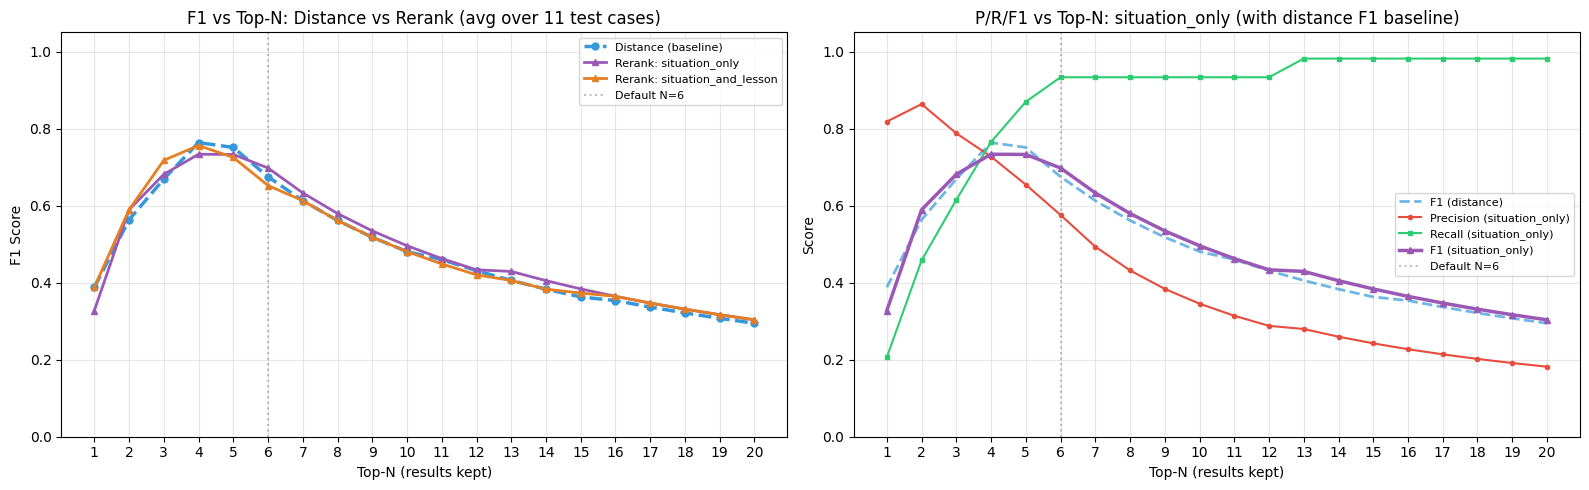

Saved: data/phase2/runs/run_20260212_181821/figures/rerank_topn_sweep.png


In [41]:
# Cell B — Top-N Sweep: Distance Baseline vs Rerank Strategies
import matplotlib.pyplot as plt
import numpy as np

FIGURES_DIR = RUN_DIR / "figures"
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

n_cases = len(successful)
max_n = 20
n_values = list(range(1, max_n + 1))


def compute_sweep(all_data, n_values, results_fn):
    """Compute P/R/F1 sweep for a given results accessor (returns list of dicts at each N)."""
    sweep_p, sweep_r, sweep_f1 = [], [], []
    for n in n_values:
        ps, rs, f1s = [], [], []
        for data in all_data:
            gt_ids = set(data.get("ground_truth", {}).get("memory_ids", []))
            gt_count = len(gt_ids)
            results = results_fn(data)
            top_n_ids = {r["id"] for r in results[:n]}
            hits = len(top_n_ids & gt_ids)
            actual_n = len(top_n_ids)
            p = hits / actual_n if actual_n > 0 else 0.0
            r = hits / gt_count if gt_count > 0 else 0.0
            f1 = 2 * p * r / (p + r) if (p + r) > 0 else 0.0
            ps.append(p)
            rs.append(r)
            f1s.append(f1)
        sweep_p.append(np.mean(ps))
        sweep_r.append(np.mean(rs))
        sweep_f1.append(np.mean(f1s))
    return np.array(sweep_p), np.array(sweep_r), np.array(sweep_f1)


# Distance baseline sweep
dist_p, dist_r, dist_f1 = compute_sweep(
    successful, n_values, lambda data: pool_and_deduplicate_by_distance(data.get("queries", []))
)

# Per-strategy rerank sweeps
strategy_sweeps = {}
for key in strategy_names:
    strategy_sweeps[key] = compute_sweep(
        successful, n_values, lambda data, k=key: get_reranked_results(data, k)
    )

# Print table
print(f"Top-N Sweep: Distance vs Rerank (averaged over {n_cases} test cases)\n")
header = f"{'N':>4} {'Dist F1':>8}"
for key in strategy_names:
    header += f" {key[:16] + ' F1':>18} {'Delta':>7}"
print(header)
print("-" * (14 + 27 * len(strategy_names)))
for n in [1, 2, 3, 4, 5, 6, 8, 10, 15, 20]:
    if n <= max_n:
        i = n - 1
        row = f"{n:>4} {dist_f1[i]:>8.3f}"
        for key in strategy_names:
            _, _, sf1 = strategy_sweeps[key]
            delta = sf1[i] - dist_f1[i]
            row += f" {sf1[i]:>18.3f} {delta:>+7.3f}"
        print(row)

# --- Plots ---
colors_rerank = ["#9b59b6", "#e67e22", "#2ecc71", "#e74c3c"]
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Left: F1 comparison — distance baseline + all strategies
ax = axes[0]
ax.plot(
    n_values,
    dist_f1,
    label="Distance (baseline)",
    color="#3498db",
    linewidth=2.5,
    marker="o",
    markersize=5,
    linestyle="--",
)
for i, key in enumerate(strategy_names):
    _, _, sf1 = strategy_sweeps[key]
    ax.plot(
        n_values,
        sf1,
        label=f"Rerank: {key}",
        color=colors_rerank[i % len(colors_rerank)],
        linewidth=2,
        marker="^",
        markersize=4,
    )
ax.axvline(
    x=RERANK_TOP_N, color="gray", linestyle=":", alpha=0.5, label=f"Default N={RERANK_TOP_N}"
)
ax.set_xlabel("Top-N (results kept)")
ax.set_ylabel("F1 Score")
ax.set_title(f"F1 vs Top-N: Distance vs Rerank (avg over {n_cases} test cases)")
ax.set_xticks(n_values)
ax.set_ylim(0, 1.05)
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Right: P/R/F1 detail for best strategy + distance baseline
best_strategy = max(strategy_names, key=lambda k: strategy_sweeps[k][2][RERANK_TOP_N - 1])
bp, br, bf1 = strategy_sweeps[best_strategy]
ax = axes[1]
ax.plot(
    n_values,
    dist_f1,
    label="F1 (distance)",
    color="#3498db",
    linewidth=2,
    linestyle="--",
    alpha=0.7,
)
ax.plot(
    n_values,
    bp,
    label=f"Precision ({best_strategy})",
    color="#e74c3c",
    linewidth=1.5,
    marker="o",
    markersize=3,
)
ax.plot(
    n_values,
    br,
    label=f"Recall ({best_strategy})",
    color="#2ecc71",
    linewidth=1.5,
    marker="s",
    markersize=3,
)
ax.plot(
    n_values,
    bf1,
    label=f"F1 ({best_strategy})",
    color="#9b59b6",
    linewidth=2.5,
    marker="^",
    markersize=4,
)
ax.axvline(
    x=RERANK_TOP_N, color="gray", linestyle=":", alpha=0.5, label=f"Default N={RERANK_TOP_N}"
)
ax.set_xlabel("Top-N (results kept)")
ax.set_ylabel("Score")
ax.set_title(f"P/R/F1 vs Top-N: {best_strategy} (with distance F1 baseline)")
ax.set_xticks(n_values)
ax.set_ylim(0, 1.05)
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

plt.tight_layout()
fig.savefig(FIGURES_DIR / "rerank_topn_sweep.png", dpi=200, bbox_inches="tight")
plt.show()
print(f"Saved: {FIGURES_DIR / 'rerank_topn_sweep.png'}")

[situation_only] GT rerank scores:     n= 41, min=0.0020, max=1.0000, mean=0.5343, median=0.6084
[situation_only] Non-GT rerank scores: n=365, min=0.0000, max=0.4743, mean=0.0187, median=0.0030
[situation_only] Mean separation: 0.5157 (moderate)
[situation_only] Per-test-case GT counts: [3, 5, 4, 2, 2, 3, 5, 4, 4, 5, 4] (total unique memories: 41)
[situation_only] Per-test-case Non-GT counts: [35, 33, 30, 38, 34, 34, 33, 31, 29, 33, 35] (total unique memories: 365)

[situation_and_lesson] GT rerank scores:     n= 41, min=0.0035, max=1.0000, mean=0.6370, median=0.7151
[situation_and_lesson] Non-GT rerank scores: n=365, min=0.0000, max=0.7069, mean=0.0331, median=0.0064
[situation_and_lesson] Mean separation: 0.6040 (moderate)
[situation_and_lesson] Per-test-case GT counts: [3, 5, 4, 2, 2, 3, 5, 4, 4, 5, 4] (total unique memories: 41)
[situation_and_lesson] Per-test-case Non-GT counts: [35, 33, 30, 38, 34, 34, 33, 31, 29, 33, 35] (total unique memories: 365)



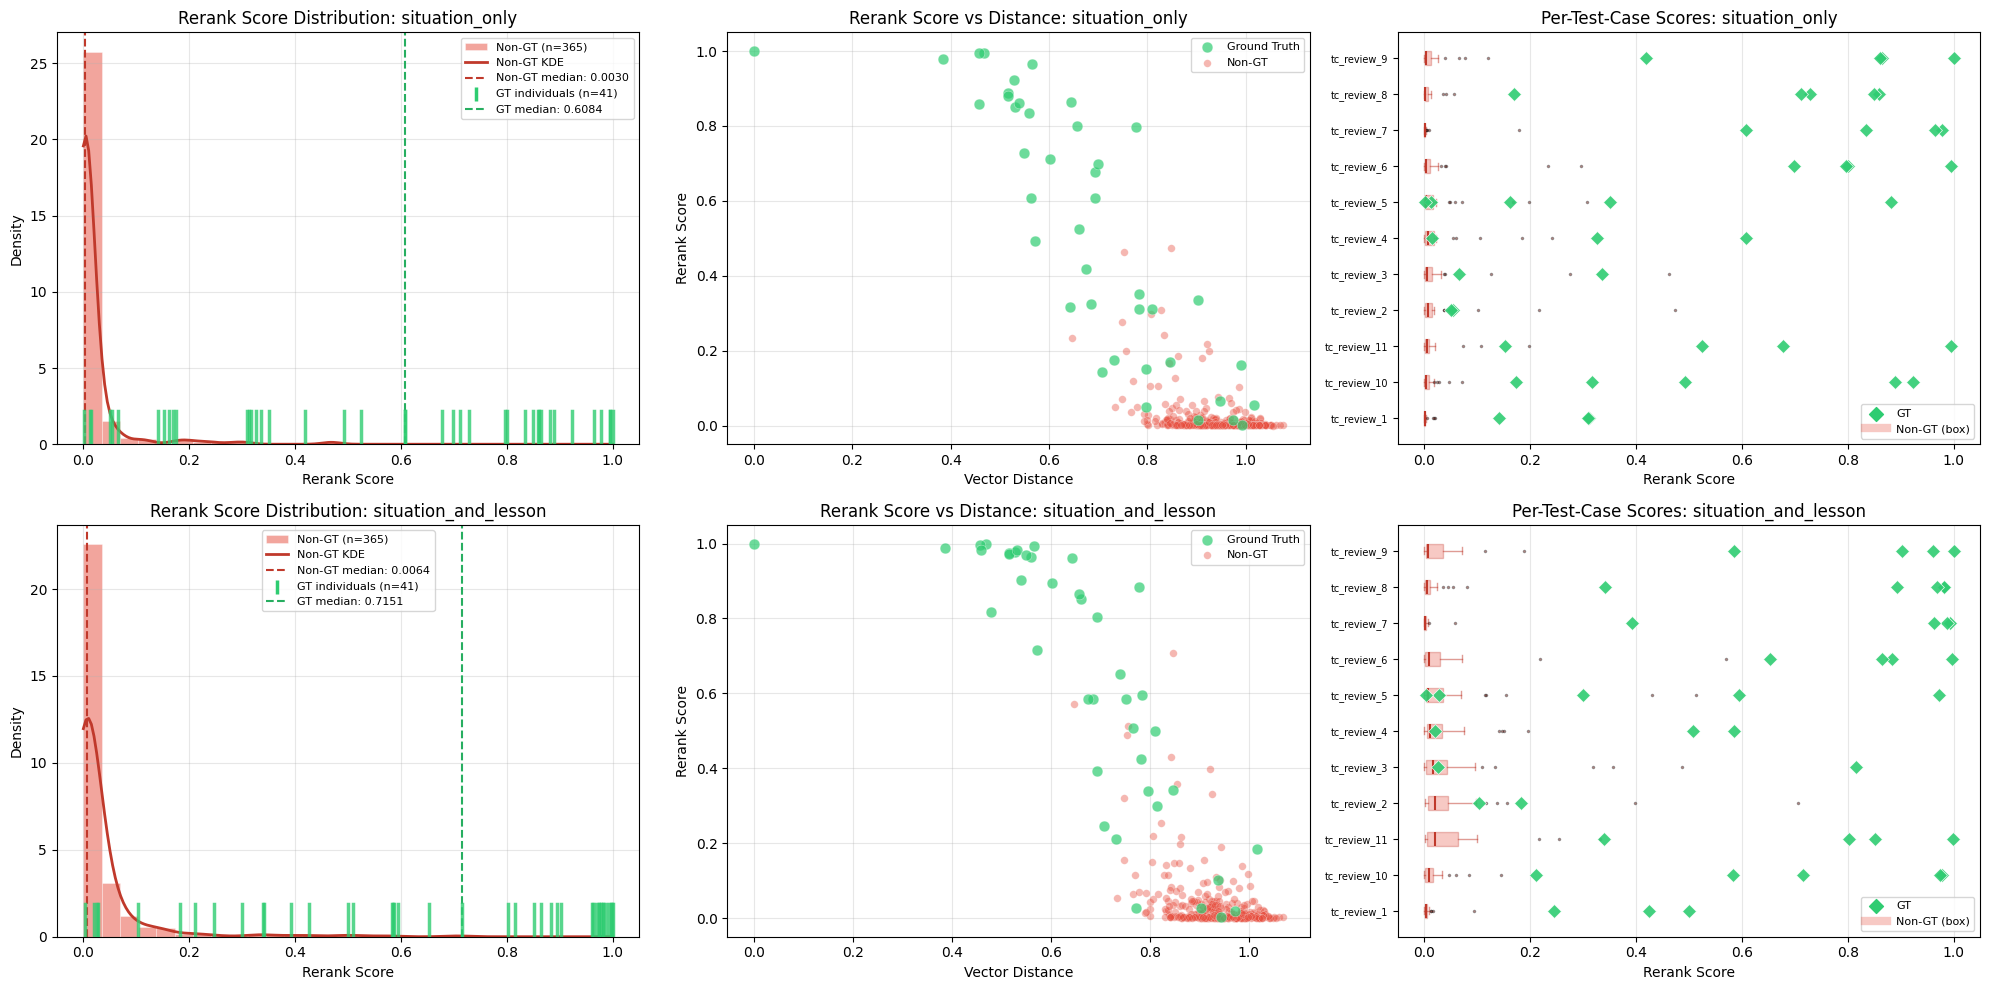

Saved: data/phase2/runs/run_20260212_181821/figures/rerank_score_distribution.png


In [42]:
# Cell C — Rerank Score Distribution (Per Strategy)
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

n_strategies = len(strategy_names)
fig, axes = plt.subplots(n_strategies, 3, figsize=(20, 5 * n_strategies), squeeze=False)

for row, key in enumerate(strategy_names):
    gt_scores, non_gt_scores = [], []
    gt_distances, non_gt_distances = [], []
    per_test_case_gt_scores = {}
    per_test_case_non_gt_scores = {}

    for data in successful:
        test_case_id = data.get("test_case_id", "?")
        test_case_label = test_case_id[:20]
        reranked = get_reranked_results(data, key)
        tc_gt, tc_non_gt = [], []
        for result in reranked:
            if result.get("is_ground_truth"):
                gt_scores.append(result["rerank_score"])
                gt_distances.append(result["distance"])
                tc_gt.append(result["rerank_score"])
            else:
                non_gt_scores.append(result["rerank_score"])
                non_gt_distances.append(result["distance"])
                tc_non_gt.append(result["rerank_score"])
        if tc_gt or tc_non_gt:
            per_test_case_gt_scores[test_case_label] = tc_gt
            per_test_case_non_gt_scores[test_case_label] = tc_non_gt

    gt_arr = np.array(gt_scores)
    non_gt_arr = np.array(non_gt_scores)

    # --- Column 1: Density histogram (non-GT) + KDE overlay + GT strip markers ---
    ax = axes[row][0]
    all_scores = (
        np.concatenate([gt_arr, non_gt_arr])
        if len(gt_arr) and len(non_gt_arr)
        else (gt_arr if len(gt_arr) else non_gt_arr)
    )
    score_min, score_max = all_scores.min(), all_scores.max()
    bins = np.linspace(score_min, score_max, 30)

    if len(non_gt_arr):
        ax.hist(
            non_gt_arr,
            bins=bins,
            alpha=0.5,
            density=True,
            label=f"Non-GT (n={len(non_gt_arr)})",
            color="#e74c3c",
            edgecolor="white",
            linewidth=0.5,
        )
        # KDE overlay for non-GT
        if len(non_gt_arr) > 3:
            kde = gaussian_kde(non_gt_arr)
            x_kde = np.linspace(score_min, score_max, 200)
            ax.plot(x_kde, kde(x_kde), color="#c0392b", linewidth=2, label="Non-GT KDE")
        ax.axvline(
            np.median(non_gt_arr),
            color="#c0392b",
            linestyle="--",
            linewidth=1.5,
            label=f"Non-GT median: {np.median(non_gt_arr):.4f}",
        )

    if len(gt_arr):
        # GT as rug/strip plot — individual vertical lines at bottom
        y_max = ax.get_ylim()[1]
        strip_height = y_max * 0.08
        for score in gt_arr:
            ax.plot(
                [score, score],
                [0, strip_height],
                color="#2ecc71",
                linewidth=2.5,
                alpha=0.8,
                zorder=5,
            )
        # Invisible scatter for legend entry
        ax.scatter(
            [],
            [],
            color="#2ecc71",
            marker="|",
            s=100,
            linewidth=2.5,
            label=f"GT individuals (n={len(gt_arr)})",
        )
        ax.axvline(
            np.median(gt_arr),
            color="#27ae60",
            linestyle="--",
            linewidth=1.5,
            label=f"GT median: {np.median(gt_arr):.4f}",
        )

    ax.set_xlabel("Rerank Score")
    ax.set_ylabel("Density")
    ax.set_title(f"Rerank Score Distribution: {key}")
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

    # --- Column 2: Rerank score vs distance scatter (unchanged) ---
    ax = axes[row][1]
    if gt_scores:
        ax.scatter(
            gt_distances,
            gt_scores,
            alpha=0.7,
            label="Ground Truth",
            color="#2ecc71",
            s=60,
            zorder=3,
            edgecolors="white",
            linewidth=0.3,
        )
    if non_gt_scores:
        ax.scatter(
            non_gt_distances,
            non_gt_scores,
            alpha=0.4,
            label="Non-GT",
            color="#e74c3c",
            s=30,
            zorder=2,
            edgecolors="white",
            linewidth=0.3,
        )
    ax.set_xlabel("Vector Distance")
    ax.set_ylabel("Rerank Score")
    ax.set_title(f"Rerank Score vs Distance: {key}")
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

    # --- Column 3: Per-test-case box/strip comparison ---
    ax = axes[row][2]
    test_case_labels = sorted(per_test_case_gt_scores.keys() | per_test_case_non_gt_scores.keys())
    y_positions = list(range(len(test_case_labels)))

    for y_pos, label in enumerate(test_case_labels):
        tc_gt = per_test_case_gt_scores.get(label, [])
        tc_non_gt = per_test_case_non_gt_scores.get(label, [])

        # Non-GT as box plot
        if tc_non_gt:
            box = ax.boxplot(
                [tc_non_gt],
                positions=[y_pos],
                vert=False,
                widths=0.4,
                patch_artist=True,
                boxprops=dict(facecolor="#e74c3c", alpha=0.3, edgecolor="#c0392b"),
                medianprops=dict(color="#c0392b", linewidth=1.5),
                whiskerprops=dict(color="#c0392b", alpha=0.5),
                capprops=dict(color="#c0392b", alpha=0.5),
                flierprops=dict(marker=".", markerfacecolor="#e74c3c", markersize=3, alpha=0.4),
                manage_ticks=False,
            )

        # GT as individual strip markers
        if tc_gt:
            ax.scatter(
                tc_gt,
                [y_pos] * len(tc_gt),
                color="#2ecc71",
                marker="D",
                s=50,
                zorder=5,
                edgecolors="white",
                linewidth=0.5,
                alpha=0.9,
            )

    ax.set_yticks(y_positions)
    ax.set_yticklabels(test_case_labels, fontsize=7)
    ax.set_xlabel("Rerank Score")
    ax.set_title(f"Per-Test-Case Scores: {key}")
    ax.grid(True, alpha=0.3, axis="x")
    # Legend
    ax.scatter([], [], color="#2ecc71", marker="D", s=50, label="GT")
    ax.plot([], [], color="#e74c3c", linewidth=6, alpha=0.3, label="Non-GT (box)")
    ax.legend(fontsize=8, loc="lower right")

    # --- Statistics ---
    if len(gt_arr):
        print(
            f"[{key}] GT rerank scores:     n={len(gt_arr):>3}, min={gt_arr.min():.4f}, max={gt_arr.max():.4f}, mean={gt_arr.mean():.4f}, median={np.median(gt_arr):.4f}"
        )
    if len(non_gt_arr):
        print(
            f"[{key}] Non-GT rerank scores: n={len(non_gt_arr):>3}, min={non_gt_arr.min():.4f}, max={non_gt_arr.max():.4f}, mean={non_gt_arr.mean():.4f}, median={np.median(non_gt_arr):.4f}"
        )
    if len(gt_arr) and len(non_gt_arr):
        separation = gt_arr.mean() - non_gt_arr.mean()
        print(
            f"[{key}] Mean separation: {separation:.4f} ({'good' if separation > 1.0 else 'moderate' if separation > 0.5 else 'weak'})"
        )
    # Per-test-case counts
    gt_per_tc = [len(per_test_case_gt_scores.get(label, [])) for label in test_case_labels]
    non_gt_per_tc = [len(per_test_case_non_gt_scores.get(label, [])) for label in test_case_labels]
    print(f"[{key}] Per-test-case GT counts: {gt_per_tc} (total unique memories: {len(gt_arr)})")
    print(
        f"[{key}] Per-test-case Non-GT counts: {non_gt_per_tc} (total unique memories: {len(non_gt_arr)})"
    )
    print()

plt.tight_layout()
fig.savefig(FIGURES_DIR / "rerank_score_distribution.png", dpi=200, bbox_inches="tight")
plt.show()
print(f"Saved: {FIGURES_DIR / 'rerank_score_distribution.png'}")

OPTIMAL THRESHOLDS PER STRATEGY
  situation_only:                threshold=0.3100  F1=0.755  P=0.864  R=0.689  MRR=0.864
  situation_and_lesson:          threshold=0.1600  F1=0.765  P=0.717  R=0.842  MRR=0.939

Best strategy: situation_and_lesson


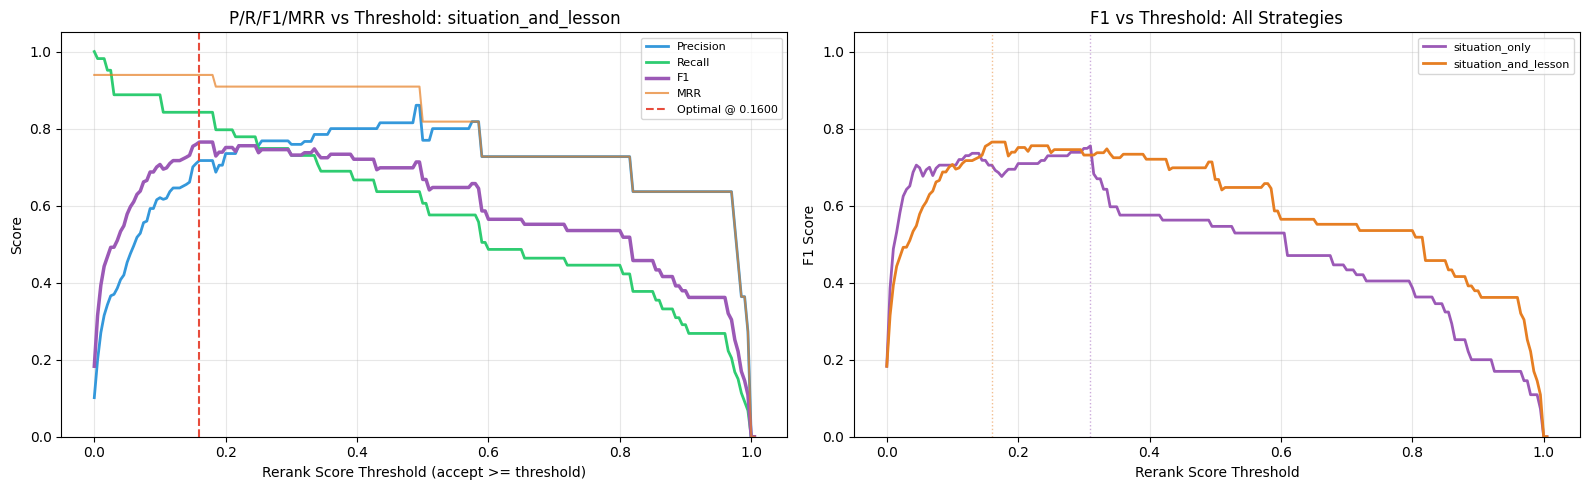

Saved: data/phase2/runs/run_20260212_181821/figures/rerank_threshold_sweep.png

Threshold table: situation_and_lesson (macro-averaged over 11 test cases)
 Threshold  Precision   Recall       F1      MRR  Avg Accepted  Avg GT Kept
---------------------------------------------------------------------------
    0.0010      0.101    1.000    0.183    0.939          32.7          3.7
    0.0050      0.199    0.982    0.315    0.939          22.2          3.6
    0.0100      0.270    0.982    0.393    0.939          17.5          3.6
    0.0200      0.343    0.952    0.467    0.939          13.7          3.5
    0.0300      0.370    0.888    0.492    0.939          11.4          3.4
    0.0500      0.453    0.888    0.578    0.939           8.3          3.4
    0.0800      0.560    0.888    0.666    0.939           6.5          3.4
    0.1000      0.621    0.888    0.707    0.939           5.9          3.4
    0.1500      0.700    0.842    0.754    0.939           4.7          3.3
    0.1600

In [43]:
# Cell D — Rerank Score Threshold Sweep (MAIN DELIVERABLE)
import matplotlib.pyplot as plt
import numpy as np

# Build per-experiment reranked data for sweep
exp_reranked_by_strategy = {}
for key in strategy_names:
    exps = []
    for data in successful:
        gt_ids = set(data.get("ground_truth", {}).get("memory_ids", []))
        reranked = get_reranked_results(data, key)
        exps.append(
            {
                "tc_id": data["test_case_id"],
                "gt_ids": gt_ids,
                "reranked": reranked,
            }
        )
    exp_reranked_by_strategy[key] = exps

# Sweep thresholds per strategy
all_max_scores = []
for key in strategy_names:
    for er in exp_reranked_by_strategy[key]:
        if er["reranked"]:
            all_max_scores.append(max(r["rerank_score"] for r in er["reranked"]))
global_max = max(all_max_scores) if all_max_scores else 1.0
sweep_thresholds = np.arange(0.0, global_max + 0.01, 0.005)

strategy_sweep_results = {}
for key in strategy_names:
    sweep_p, sweep_r, sweep_f1, sweep_mrr = [], [], [], []
    for t in sweep_thresholds:
        ps, rs, f1s, rrs = [], [], [], []
        for er in exp_reranked_by_strategy[key]:
            accepted = {r["id"] for r in er["reranked"] if r["rerank_score"] >= t}
            gt_hit = len(accepted & er["gt_ids"])
            n_acc = len(accepted)
            gt_count = len(er["gt_ids"])
            p = gt_hit / n_acc if n_acc > 0 else 0.0
            r = gt_hit / gt_count if gt_count > 0 else 0.0
            f1 = 2 * p * r / (p + r) if (p + r) > 0 else 0.0
            ps.append(p)
            rs.append(r)
            f1s.append(f1)
            # MRR
            accepted_sorted = [r for r in er["reranked"] if r["rerank_score"] >= t]
            rr = 0.0
            for rank, res in enumerate(accepted_sorted, 1):
                if res["id"] in er["gt_ids"]:
                    rr = 1.0 / rank
                    break
            rrs.append(rr)
        sweep_p.append(np.mean(ps))
        sweep_r.append(np.mean(rs))
        sweep_f1.append(np.mean(f1s))
        sweep_mrr.append(np.mean(rrs))

    sweep_p = np.array(sweep_p)
    sweep_r = np.array(sweep_r)
    sweep_f1 = np.array(sweep_f1)
    sweep_mrr = np.array(sweep_mrr)
    best_idx = np.argmax(sweep_f1)
    strategy_sweep_results[key] = {
        "p": sweep_p,
        "r": sweep_r,
        "f1": sweep_f1,
        "mrr": sweep_mrr,
        "best_idx": best_idx,
        "best_threshold": sweep_thresholds[best_idx],
    }

# --- Print optimal thresholds ---
print("OPTIMAL THRESHOLDS PER STRATEGY")
best_overall_strategy = None
best_overall_f1 = -1
for key in strategy_names:
    sr = strategy_sweep_results[key]
    bi = sr["best_idx"]
    print(
        f"  {key + ':':30} threshold={sr['best_threshold']:.4f}  F1={sr['f1'][bi]:.3f}  P={sr['p'][bi]:.3f}  R={sr['r'][bi]:.3f}  MRR={sr['mrr'][bi]:.3f}"
    )
    if sr["f1"][bi] > best_overall_f1:
        best_overall_f1 = sr["f1"][bi]
        best_overall_strategy = key

print(f"\nBest strategy: {best_overall_strategy}")

# --- Plots ---
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Left: P/R/F1/MRR vs threshold for best strategy
sr = strategy_sweep_results[best_overall_strategy]
ax = axes[0]
ax.plot(sweep_thresholds, sr["p"], label="Precision", color="#3498db", linewidth=2)
ax.plot(sweep_thresholds, sr["r"], label="Recall", color="#2ecc71", linewidth=2)
ax.plot(sweep_thresholds, sr["f1"], label="F1", color="#9b59b6", linewidth=2.5)
ax.plot(sweep_thresholds, sr["mrr"], label="MRR", color="#e67e22", linewidth=1.5, alpha=0.7)
ax.axvline(
    sr["best_threshold"],
    color="#e74c3c",
    linestyle="--",
    linewidth=1.5,
    label=f"Optimal @ {sr['best_threshold']:.4f}",
)
ax.set_xlabel("Rerank Score Threshold (accept >= threshold)")
ax.set_ylabel("Score")
ax.set_title(f"P/R/F1/MRR vs Threshold: {best_overall_strategy}")
ax.legend(fontsize=8)
ax.set_ylim(0, 1.05)
ax.grid(True, alpha=0.3)

# Right: F1 vs threshold for ALL strategies
ax = axes[1]
colors_strat = ["#9b59b6", "#e67e22", "#2ecc71", "#e74c3c"]
for i, key in enumerate(strategy_names):
    sr_i = strategy_sweep_results[key]
    ax.plot(
        sweep_thresholds,
        sr_i["f1"],
        label=key,
        color=colors_strat[i % len(colors_strat)],
        linewidth=2,
    )
    ax.axvline(
        sr_i["best_threshold"],
        color=colors_strat[i % len(colors_strat)],
        linestyle=":",
        alpha=0.5,
        linewidth=1,
    )
ax.set_xlabel("Rerank Score Threshold")
ax.set_ylabel("F1 Score")
ax.set_title("F1 vs Threshold: All Strategies")
ax.legend(fontsize=8)
ax.set_ylim(0, 1.05)
ax.grid(True, alpha=0.3)

plt.tight_layout()
fig.savefig(FIGURES_DIR / "rerank_threshold_sweep.png", dpi=200, bbox_inches="tight")
plt.show()
print(f"Saved: {FIGURES_DIR / 'rerank_threshold_sweep.png'}")

# --- Threshold table for best strategy ---
sr = strategy_sweep_results[best_overall_strategy]
bt = sr["best_threshold"]
print(
    f"\nThreshold table: {best_overall_strategy} (macro-averaged over {len(successful)} test cases)"
)
print(
    f"{'Threshold':>10} {'Precision':>10} {'Recall':>8} {'F1':>8} {'MRR':>8} {'Avg Accepted':>13} {'Avg GT Kept':>12}"
)
print("-" * 75)

table_thresholds = sorted(
    set(
        [
            0.001,
            0.005,
            0.01,
            0.02,
            0.03,
            0.05,
            0.08,
            0.10,
            0.15,
            0.20,
            0.30,
            0.50,
            round(bt, 4),
        ]
    )
)
exps = exp_reranked_by_strategy[best_overall_strategy]
for t in table_thresholds:
    if t > global_max + 0.01:
        continue
    idx = np.argmin(np.abs(sweep_thresholds - t))
    avg_accepted = np.mean(
        [len([r for r in er["reranked"] if r["rerank_score"] >= t]) for er in exps]
    )
    avg_gt_kept = np.mean(
        [
            len({r["id"] for r in er["reranked"] if r["rerank_score"] >= t} & er["gt_ids"])
            for er in exps
        ]
    )
    marker = " <-- optimal" if abs(t - bt) < 0.003 else ""
    print(
        f"{t:>10.4f} {sr['p'][idx]:>10.3f} {sr['r'][idx]:>8.3f} {sr['f1'][idx]:>8.3f} {sr['mrr'][idx]:>8.3f} {avg_accepted:>13.1f} {avg_gt_kept:>12.1f}{marker}"
    )

In [44]:
# Cell E — Per-Test-Case Impact at Optimal Threshold
import numpy as np

N = RERANK_TOP_N
key = best_overall_strategy
bt = strategy_sweep_results[key]["best_threshold"]
exps = exp_reranked_by_strategy[key]

print("Per-test-case comparison at best strategy's optimal threshold")
print(f"  Strategy: {key}")
print(f"  Threshold: score >= {bt:.4f}")
print(f"  Distance baseline: top-{N} by distance")
print()

print(
    f"{'Test Case':<20} {'Dist F1':>8} {'Thr F1':>8} {'Delta':>8} {'Dist P':>7} {'Thr P':>7} {'Dist R':>7} {'Thr R':>7} {'D Acc':>6} {'T Acc':>6} {'GT':>4}"
)
print("-" * 105)

dist_f1s, thr_f1s = [], []

for data, er in zip(successful, exps):
    tc_id = data["test_case_id"]
    gt_ids = er["gt_ids"]
    gt_count = len(gt_ids)

    # Distance baseline: top-N
    pooled = pool_and_deduplicate_by_distance(data.get("queries", []))
    dist_top = pooled[:N]
    dist_ids = {r["id"] for r in dist_top}
    d_h = len(dist_ids & gt_ids)
    d_n = len(dist_ids)
    d_p = d_h / d_n if d_n else 0
    d_r = d_h / gt_count if gt_count else 0
    d_f1 = 2 * d_p * d_r / (d_p + d_r) if (d_p + d_r) else 0

    # Threshold-based
    thr_results = [r for r in er["reranked"] if r["rerank_score"] >= bt]
    thr_ids = {r["id"] for r in thr_results}
    t_h = len(thr_ids & gt_ids)
    t_n = len(thr_ids)
    t_p = t_h / t_n if t_n else 0
    t_r = t_h / gt_count if gt_count else 0
    t_f1 = 2 * t_p * t_r / (t_p + t_r) if (t_p + t_r) else 0

    delta = t_f1 - d_f1
    marker = "+" if delta > 0.001 else "-" if delta < -0.001 else "="
    print(
        f"{tc_id:<20} {d_f1:>8.3f} {t_f1:>8.3f} {delta:>+7.3f}{marker} {d_p:>7.1%} {t_p:>7.1%} {d_r:>7.1%} {t_r:>7.1%} {d_n:>6} {t_n:>6} {gt_count:>4}"
    )

    # Show missed GT with their rerank scores
    missed = gt_ids - thr_ids
    if missed:
        for mid in sorted(missed):
            score = next((r["rerank_score"] for r in er["reranked"] if r["id"] == mid), None)
            if score is not None:
                print(f"  {'':20} Missed: {mid}  score={score:.4f} (below threshold {bt:.4f})")
            else:
                print(f"  {'':20} Missed: {mid}  NOT IN CANDIDATE POOL (query miss)")

    dist_f1s.append(d_f1)
    thr_f1s.append(t_f1)

avg_d = np.mean(dist_f1s)
avg_t = np.mean(thr_f1s)
delta = avg_t - avg_d
print("-" * 105)
print(
    f"{'AVERAGE':<20} {avg_d:>8.3f} {avg_t:>8.3f} {delta:>+7.3f}{'+' if delta > 0.001 else '-' if delta < -0.001 else '='}"
)

improved = sum(1 for d, t in zip(dist_f1s, thr_f1s) if t > d + 0.001)
same = sum(1 for d, t in zip(dist_f1s, thr_f1s) if abs(t - d) <= 0.001)
worse = sum(1 for d, t in zip(dist_f1s, thr_f1s) if t < d - 0.001)
print(
    f"\nThreshold helped: {improved}/{len(successful)} | Same: {same}/{len(successful)} | Hurt: {worse}/{len(successful)}"
)

Per-test-case comparison at best strategy's optimal threshold
  Strategy: situation_and_lesson
  Threshold: score >= 0.1600
  Distance baseline: top-6 by distance

Test Case             Dist F1   Thr F1    Delta  Dist P   Thr P  Dist R   Thr R  D Acc  T Acc   GT
---------------------------------------------------------------------------------------------------------
tc_review_10            0.909    1.000  +0.091+   83.3%  100.0%  100.0%  100.0%      6      5    5
tc_review_11            0.800    0.727  -0.073-   66.7%   57.1%  100.0%  100.0%      6      7    4
tc_review_1             0.667    1.000  +0.333+   50.0%  100.0%  100.0%  100.0%      6      3    3
tc_review_2             0.250    0.400  +0.150+   16.7%   33.3%   50.0%   50.0%      6      3    2
                       Missed: mem_07280a7a2efe  score=0.1027 (below threshold 0.1600)
tc_review_3             0.500    0.333  -0.167-   33.3%   25.0%  100.0%   50.0%      6      4    2
                       Missed: mem_dd13dcd5d263  